<a href="https://colab.research.google.com/github/ShraddhaSharma24/Machine-learning/blob/main/PowerGrid_IDS_Machine_Learning_Based_Intrusion_Detection_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd

# Simulate Power System Data
num_samples = 1000
time = np.arange(0, num_samples)
voltage = np.sin(time / 100) + 0.1 * np.random.randn(num_samples)
current = np.cos(time / 50) + 0.05 * np.random.randn(num_samples)
power_flow = voltage * current + 0.1 * np.random.randn(num_samples)

# Create a DataFrame for simulated power system data
data = pd.DataFrame({
    'Time': time,
    'Voltage': voltage,
    'Current': current,
    'Power Flow': power_flow
})

# Introduce "cyber-attacks" (abnormal data points)

# Attack 1: False Data Injection (Incorrect readings on voltage and power flow)
data.iloc[200:250, 1] += 1.5  # False data injection in Voltage
data.iloc[200:250, 3] += 1.5  # False data injection in Power Flow

# Attack 2: Denial of Service (DoS) (Large spikes in data)
data.iloc[500:550, 1] += 10  # Voltage spike (DoS attack)
data.iloc[500:550, 2] += 10  # Current spike (DoS attack)

# Attack 3: Replay Attack (Replaying old values as if they are real-time)
data.iloc[800:850, 1] = data.iloc[100:150, 1].values  # Replay Voltage
data.iloc[800:850, 3] = data.iloc[100:150, 3].values  # Replay Power Flow

# Attack 4: Data Manipulation (Injecting noise or manipulated values)
data.iloc[400:450, 2] += 5  # Manipulated Current readings

# Save the simulated data to a CSV file
data.to_csv('simulated_power_system_cyber_attack_data.csv', index=False)

# Show the first few rows
data.head()


,Time,Voltage,Current,Power Flow
0,0,0.143391,1.033092,0.107620
1,1,-0.099855,0.963393,-0.106115
2,2,0.156734,0.946555,0.197950
3,3,0.175328,0.939294,0.166103
4,4,0.067845,0.972866,0.233363


In [6]:
from sklearn.preprocessing import StandardScaler

# Load the simulated dataset
data = pd.read_csv('simulated_power_system_cyber_attack_data.csv')

# Extract features (excluding time)
X = data[['Voltage', 'Current', 'Power Flow']]

# Scale the features to normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optionally, if you have attack labels, you can create a binary target variable
# In this case, let's assume that rows with attacks are labeled as 1, and normal data as 0
y = np.zeros(len(data))
y[200:250] = 1  # False data injection
y[500:550] = 1  # DoS attack
y[800:850] = 1  # Replay attack
y[400:450] = 1  # Data manipulation


In [7]:
from sklearn.ensemble import IsolationForest

# Use Isolation Forest for anomaly detection
model = IsolationForest(n_estimators=100, contamination=0.1)  # Assumes 10% anomalies
model.fit(X_scaled)

# Predict anomalies
y_pred = model.predict(X_scaled)

# -1 for anomalies (attacks), 1 for normal data
y_pred = np.where(y_pred == 1, 0, 1)  # Convert to binary labels (0 = normal, 1 = attack)

# Evaluate the model's performance
from sklearn.metrics import classification_report
print(classification_report(y, y_pred))


              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94       800
         1.0       0.97      0.48      0.65       200

    accuracy                           0.89      1000
   macro avg       0.93      0.74      0.79      1000
weighted avg       0.90      0.89      0.88      1000



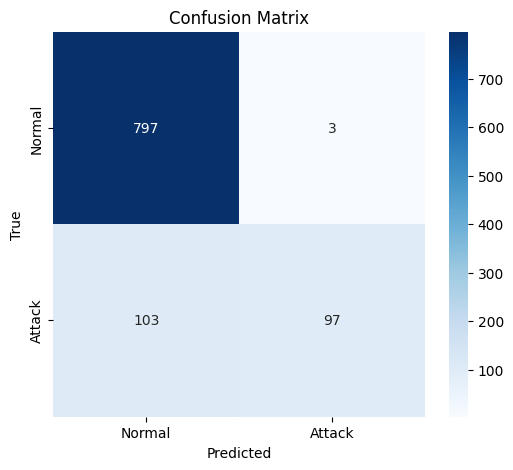

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


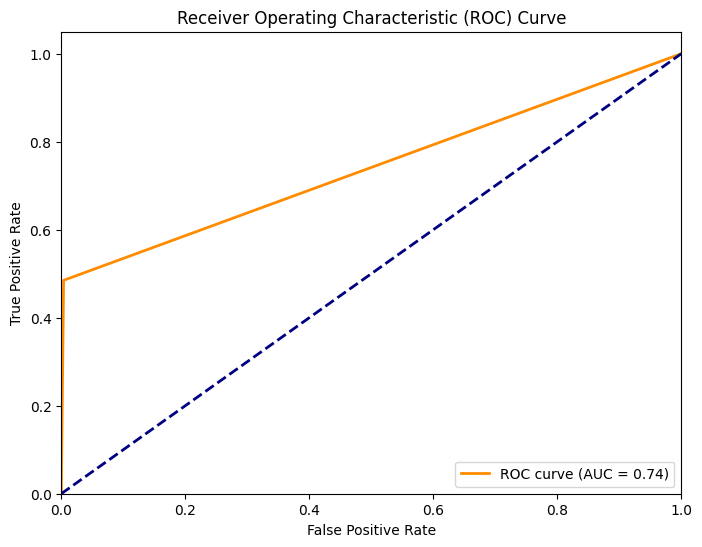

In [9]:
from sklearn.metrics import roc_curve, auc

# Compute the false positive rate and true positive rate for ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred)

# Calculate the AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


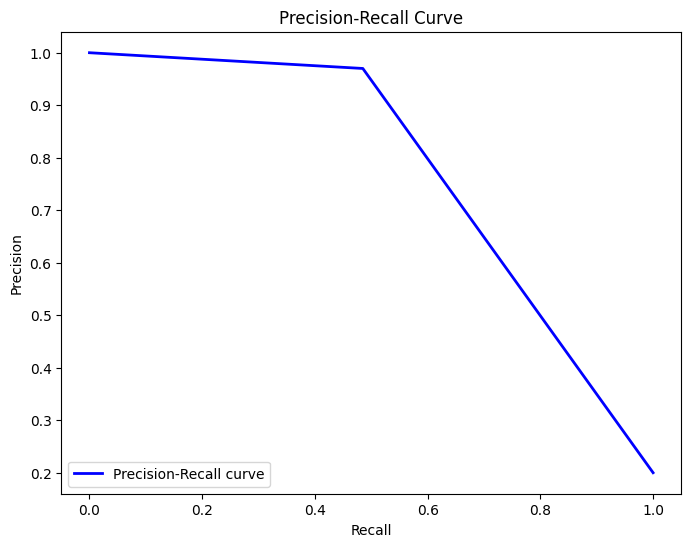

Average Precision: 0.57


In [10]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y, y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Compute the average precision score
avg_precision = average_precision_score(y, y_pred)
print(f'Average Precision: {avg_precision:.2f}')


In [11]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 89.40%


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Classifier Evaluation:")
print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_rf)}")


Random Forest Classifier Evaluation:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       160
         1.0       0.97      0.88      0.92        40

    accuracy                           0.97       200
   macro avg       0.97      0.93      0.95       200
weighted avg       0.97      0.97      0.97       200

ROC AUC: 0.934375


In [14]:
from sklearn.svm import SVC

# Initialize the SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Predictions on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
print("Support Vector Machine (SVM) Evaluation:")
print(classification_report(y_test, y_pred_svm))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_svm)}")


Support Vector Machine (SVM) Evaluation:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       160
         1.0       1.00      0.78      0.87        40

    accuracy                           0.95       200
   macro avg       0.97      0.89      0.92       200
weighted avg       0.96      0.95      0.95       200

ROC AUC: 0.8875


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Define the neural network model
def create_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification (0 for normal, 1 for attack)

    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create and train the model
nn_model = create_nn_model(X_train.shape[1])
nn_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Evaluate the model
nn_loss, nn_accuracy = nn_model.evaluate(X_test, y_test)
print("Neural Network Evaluation:")
print(f"Accuracy: {nn_accuracy}")


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6465 - loss: 1.1146
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9104 - loss: 0.8612  
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9355 - loss: 0.6971 
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9533 - loss: 0.5616 
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9568 - loss: 0.4725 
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9566 - loss: 0.4167 
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9488 - loss: 0.3802 
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9437 - loss: 0.3584
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9511 - loss: 0.3266
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9568 - loss: 0.2922 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9615 - loss: 0.2637  
Neural Network Evaluation:
Accuracy: 0.9549999833106995


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout

# Reshape X_train for CNN (add a channel dimension)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

def create_cnn_model(input_shape):
    model = Sequential([
        tf.keras.layers.Input(shape=input_shape),  # Correct input definition
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2, padding='same'),  # Prevent reducing too much
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2, padding='same'),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Use 'softmax' if multi-class
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
cnn_model = create_cnn_model(X_train_cnn.shape[1:])  # Pass correct shape
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, verbose=1)

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {test_acc:.4f}")



Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8978 - loss: 0.5797
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9411 - loss: 0.3025
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9502 - loss: 0.1914
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9555 - loss: 0.1413
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9615 - loss: 0.1182
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9490 - loss: 0.1380
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9408 - loss: 0.1430
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9499 - loss: 0.1355
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9531 - loss: 0.1250
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9498 - loss: 0.1228
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9634 - loss: 0.0821 
Test Accuracy: 0.9600


In [19]:
from sklearn.metrics import classification_report, roc_auc_score

# Evaluate Random Forest
y_pred_rf = rf_model.predict(X_test)
print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_rf)}")

# Evaluate SVM
y_pred_svm = svm_model.predict(X_test)
print("SVM:")
print(classification_report(y_test, y_pred_svm))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_svm)}")



# Evaluate Neural Network
nn_loss, nn_accuracy = nn_model.evaluate(X_test, y_test)
print("Neural Network:")
print(f"Accuracy: {nn_accuracy}")

# Evaluate CNN
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test)
print("CNN:")
print(f"Accuracy: {cnn_accuracy}")


Random Forest:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       160
         1.0       0.97      0.88      0.92        40

    accuracy                           0.97       200
   macro avg       0.97      0.93      0.95       200
weighted avg       0.97      0.97      0.97       200

ROC AUC: 0.934375
SVM:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       160
         1.0       1.00      0.78      0.87        40

    accuracy                           0.95       200
   macro avg       0.97      0.89      0.92       200
weighted avg       0.96      0.95      0.95       200

ROC AUC: 0.8875
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9615 - loss: 0.2637
Neural Network:
Accuracy: 0.9549999833106995
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9634 - loss: 0.0821
CNN:
Accuracy: 0.9599999785423279
